# importing libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
from PIL import Image
ComputeLB = False

In [2]:
if ComputeLB: PATH = '../input/animefacedataset/'
else: PATH = '../input/animefacedataset/images/'
images = os.listdir(PATH)
print('There are :',len(images),"I'm taking 10 images") 
print(images[:10])

There are : 63565 I'm taking 10 images
['35715_2011.jpg', '48610_2014.jpg', '34719_2011.jpg', '40266_2012.jpg', '4199_2002.jpg', '40739_2013.jpg', '42515_2013.jpg', '52482_2015.jpg', '46555_2014.jpg', '11579_2005.jpg']


In [3]:
os.path.isdir('../tmp')

False

# Visualizing the images

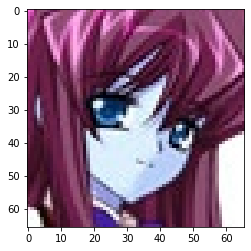

In [4]:
import cv2
plt.imshow(cv2.imread('../input/animefacedataset/images/10016_2004.jpg'))

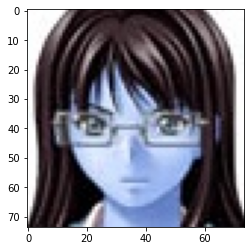

In [5]:
plt.imshow(cv2.imread('../input/animefacedataset/images/1000_2000.jpg'))

# Generating 200000 images by croping the images we have

In [6]:
os.mkdir('../tmp')
os.mkdir('../tmp/images')


for i in range(200000):
    img = Image.open(PATH + images[i%len(images)])
    img = img.resize(( 100,int(img.size[1]/(img.size[0]/100) )), Image.ANTIALIAS)
    w = img.size[0]; h = img.size[1]; a=0; b=0
    if w>64: a = np.random.randint(0,w-64)
    if h>64: b = np.random.randint(0,h-64)
    img = img.crop((a, b, 64+a, 64+b))
    img.save('../tmp/images/'+str(i)+'.png','PNG')
    if i%100000==0: print('created',i,'cropped images')
print('created 200000 cropped images')

created 0 cropped images
created 100000 cropped images
created 200000 cropped images


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

BATCH_SIZE = 256; EPOCHS = 10
train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory('../tmp/',
                target_size=(64,64), 
                shuffle=True, 
                class_mode='input', 
                batch_size=BATCH_SIZE)

Found 200000 images belonging to 1 classes.


# Building an Autoencoder

In [15]:
# ENCODER
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(99, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='mse')

In [16]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 48)        1344      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 99)        42867     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 99)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 192)       171264    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 192)         0   

In [17]:
history = autoencoder.fit(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        epochs = EPOCHS, verbose=2)

Epoch 1/10
781/781 - 99s - loss: 0.0158
Epoch 2/10
781/781 - 98s - loss: 0.0070
Epoch 3/10
781/781 - 98s - loss: 0.0058
Epoch 4/10
781/781 - 99s - loss: 0.0052
Epoch 5/10
781/781 - 98s - loss: 0.0048
Epoch 6/10
781/781 - 98s - loss: 0.0045
Epoch 7/10
781/781 - 96s - loss: 0.0042
Epoch 8/10
781/781 - 98s - loss: 0.0040
Epoch 9/10
781/781 - 99s - loss: 0.0039
Epoch 10/10
781/781 - 98s - loss: 0.0038


# Reconstructed images

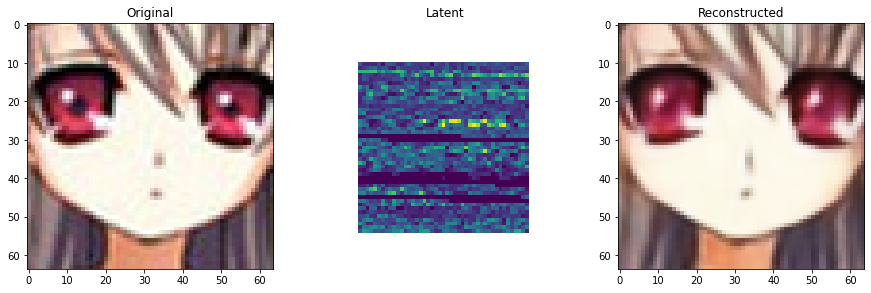

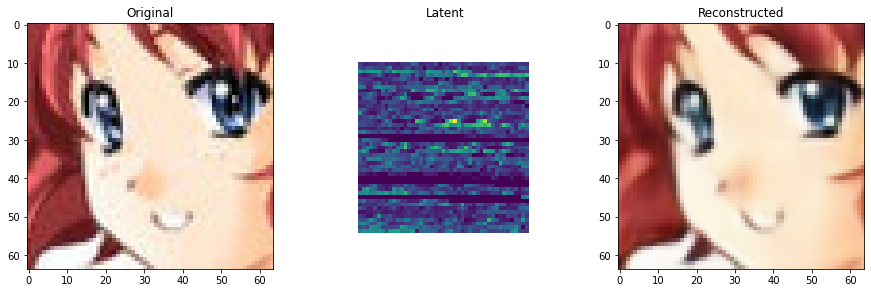

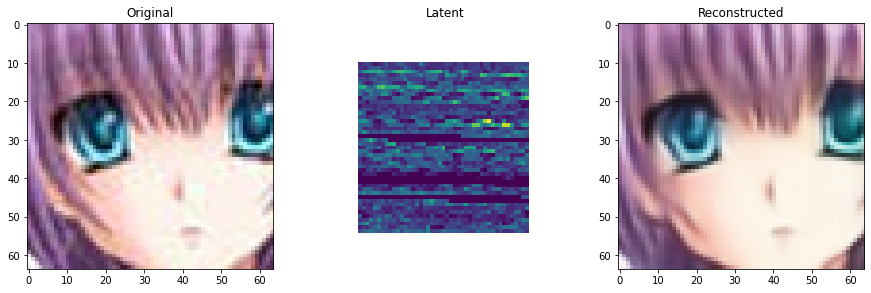

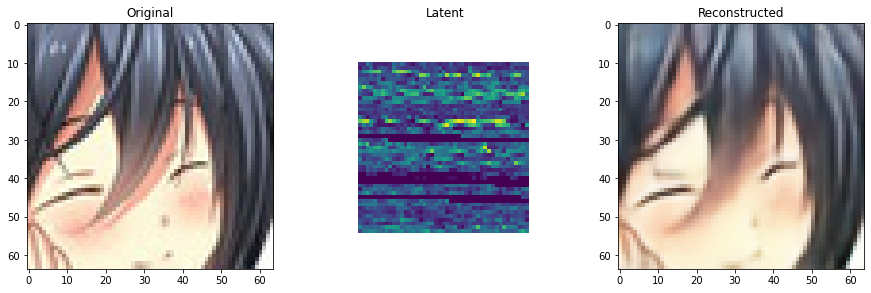

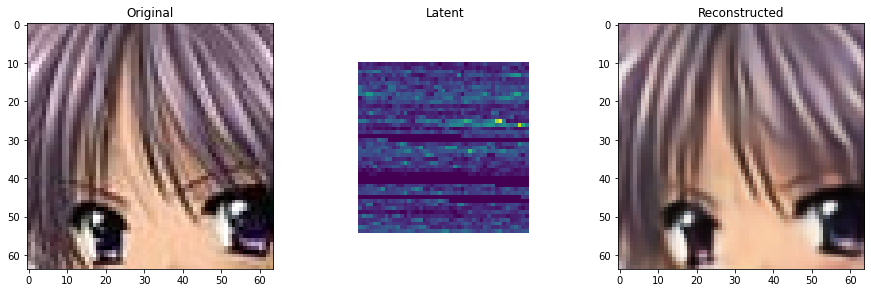

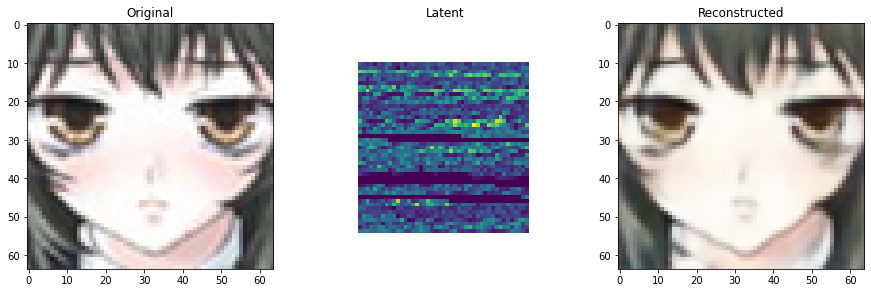

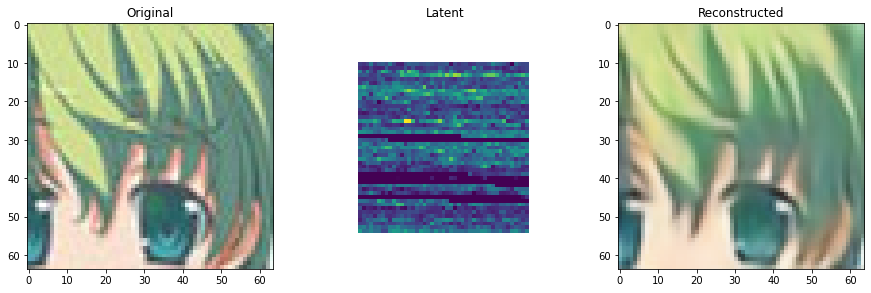

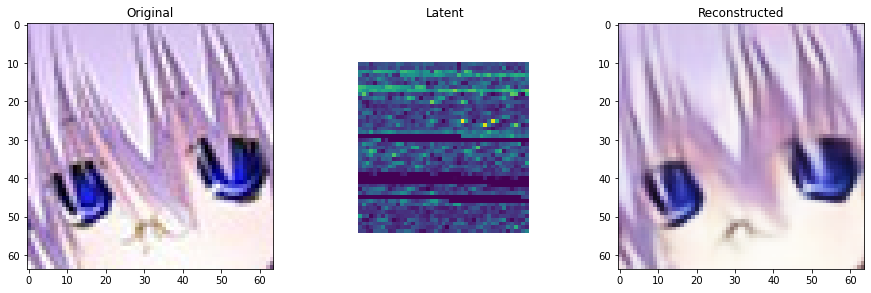

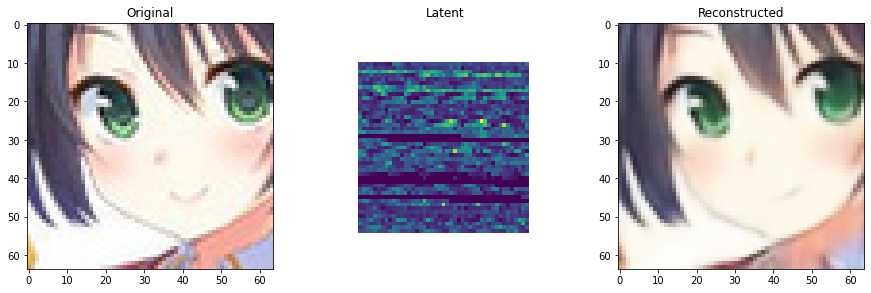

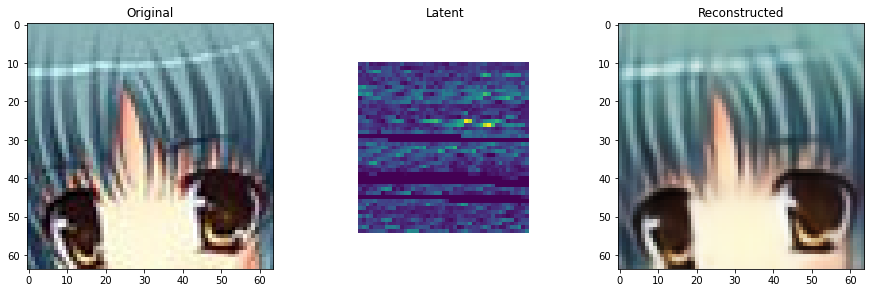

In [18]:
images = next(iter(train_batches))[0]
for i in range(10):

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

# Our original input dimension was 12288 and the output dimension is 2048. Infact we compressed the image 6X or in otherwords latent space only uses 16.6% of the original dimension.